In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

def load_data(ticker):

    filename = '../data/' + ticker + '_1min_firstratedata.csv'
    df = pd.read_csv(filename)
    df['ticker'] = ticker

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["date"] = df["timestamp"].dt.date
    df["time"] = df["timestamp"].dt.time
    return df

ticker = 'SPY'
df = load_data(ticker)

In [10]:
# Add the RSI indicator with period n to a df

def RSI(df, n):
    "function to calculate RSI"
    delta = df["close"].diff()
    delta = delta[1:]
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    df["up"] = up.round(4)
    df["down"] = down.round(4)
    AVG_Gain = df["up"].rolling(window=n).mean()
    AVG_Loss = abs(df["down"].rolling(window=n).mean())
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    df["RSI_14"] = RSI.round(4)
    df = df.drop(columns=["up", "down"])

    return df

df = RSI(df, 14)

#df.head()

In [11]:
import datetime
import pandas as pd

def simulate_trade_RSI(date, entry, exit_high, exit_low, max_trades, df):
    df_day = df[(df["date"] == date) & (df["time"] >= datetime.time(9, 30, 0)) & (df["time"] <= datetime.time(16, 0, 0))]
    trade_log = pd.DataFrame(columns=["Date", "Direction", "Entry", "Exit", "TimeEnter", "TimeExit", "Gain%", "Gain$"])
    trades, in_trade = 0, False

    for i in range(1, len(df_day)):
        rsi_condition = (df_day["RSI_14"].iloc[i - 1] < entry and df_day["RSI_14"].iloc[i] >= entry)
        exit_condition = (df_day["RSI_14"].iloc[i - 1] > exit_high or df_day["RSI_14"].iloc[i] <= exit_low)
        
        if not in_trade and rsi_condition:
            entry_price, in_trade, time_enter = df_day["close"].iloc[i], True, df_day["time"].iloc[i - 1]

        elif in_trade and (exit_condition or i == len(df_day) - 1):
            exit_price = df_day["close"].iloc[i]
            trade_gain_percent = round(((exit_price - entry_price) / entry_price) * 100, 2)
            trade_gain_net = round(exit_price - entry_price, 2)

            trade_log.loc[len(trade_log)] = pd.Series({
                "Date": date,
                "Direction": "Long",
                "Entry": entry_price,
                "Exit": exit_price,
                "TimeEnter": time_enter,
                "TimeExit": df_day["time"].iloc[i],
                "Gain%": trade_gain_percent,
                "Gain$": trade_gain_net
            })

            trades, entry_price, in_trade = trades + 1, 0, False

            # Check if the maximum number of trades is reached
            if trades >= max_trades:
                break

    return trade_log


In [12]:
# Combine the simulated trades for a range of dates into a single dataframe

def simulate_date_range(start_date, end_date, entry, exit_high, exit_low, max_trades, df):
    day_datas = []

    for n in range((end_date - start_date).days + 1):
        date = start_date + datetime.timedelta(n)
        day_data = simulate_trade_RSI(date, entry, exit_high, exit_low, max_trades, df)
        if day_data is not None:
            day_datas.append(day_data)

    day_datas = pd.concat(day_datas, ignore_index=True)

    return day_datas

In [13]:
trades = simulate_date_range(datetime.date(2022, 9, 30), datetime.date(2023, 9, 30), 30, 70, 20, 1, df)

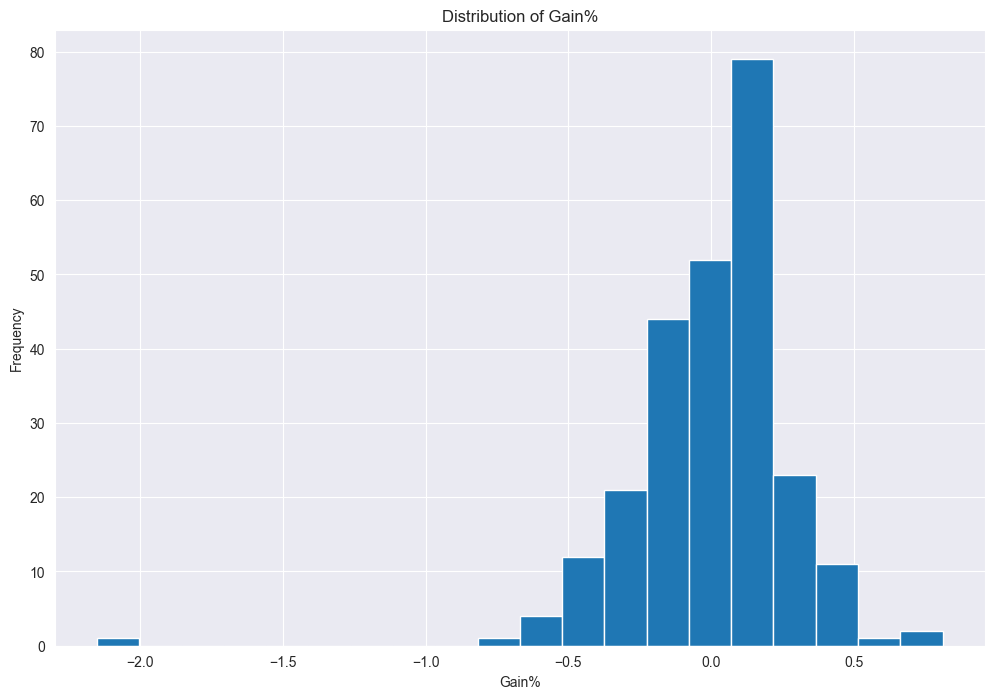

In [20]:
trades
# histogram of the trade gain%

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.hist(trades["Gain%"], bins=20)
plt.xlabel("Gain%")
plt.ylabel("Frequency")
plt.title("Distribution of Gain%")
plt.show()

In [15]:
def rsi_ranged_backtest_single_pnl(df, rsi_enter, rsi_exit, maxTrades, ticker):
    res = pd.DataFrame()
    res.loc[0, 'Ticker'] = ticker
    res.loc[0, 'StartDate'] = df['Date'].min()
    res.loc[0, 'EndDate'] = df['Date'].max()
    res.loc[0, 'Entry'] = rsi_enter
    res.loc[0, 'Exit'] = rsi_exit,
    res.loc[0, 'MaxTrades'] = maxTrades,
    res.loc[0, 'TotalTrades'] = len(df)
    res.loc[0, 'TotalPercentGain'] = round(df['Gain%'].sum(), 2)
    res.loc[0, 'AveragePercentGain'] = round(df['Gain%'].mean(), 2)
    res.loc[0, 'MaxPercentGain'] = round(df['Gain%'].max(), 2)
    res.loc[0, 'MinPercentGain'] = round(df['Gain%'].min(), 2)

    return res

In [16]:
def multi_rsi_backtest(tickers, max_trades, indicator_pairs):
    results = pd.DataFrame(
        columns=[
            "Ticker","StartDate","EndDate","Entry","Exit","TotalTrades",
            "TotalPercentGain","AveragePercentGain","MaxPercentGain","MinPercentGain"])

    for e in indicator_pairs:
        for f in max_trades:
            for g in tickers:

                df = load_data(g)
                df = RSI(df, 14)

                print("testing TICKER/ENTER/EXIT/MAXTRADES:", g, e[0], e[1], f)
                trades = simulate_date_range(datetime.date(2022, 9, 30), datetime.date(2023, 9, 30), e[0], e[1], f, df)
                pnl = rsi_ranged_backtest_single_pnl(trades, e[0], e[1], f, g)
                results.loc[len(results)] = pnl.loc[0]

    results = results.sort_values(by=["TotalPercentGain"], ascending=False)
    return results